# Выбор локации для скважины
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Основные-настройки" data-toc-modified-id="Основные-настройки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Основные настройки</a></span><ul class="toc-item"><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Библиотеки</a></span></li><li><span><a href="#Константы" data-toc-modified-id="Константы-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Константы</a></span></li></ul></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

Значения в датасетах:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Основные настройки

### Библиотеки

In [1]:
# для вывода
from IPython.display import Markdown, display 

# для работы с данными
import pandas as pd
import numpy as np

# для графики
import seaborn as sns
from matplotlib import pyplot as plt

# для обучения
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Константы

In [2]:
# Бюджет на разработку скважин в регионе — 10 млрд рублей
BUILD_BUDGET = int(10e9)
# Доход с каждой единицы продукта составляет 450 тыс. рублей
UNIT_INCOME = 450000
# Количество скважин для исследования в регионе
WELLS_CNT = 500
# Количество скважин для разработки в регионе
BEST_WELLS_CNT = 200
# Фиксируем случайное состояние
RANDOM_STATE = 123

## Загрузка и подготовка данных

In [3]:
dir = '../datasets/'

# словарь с датафреймами, который заполним по циклу
data = {'geo_data_0'   : None,
        'geo_data_1'   : None,
        'geo_data_2'   : None}

for name in data:
    # считывание
    data[name] = pd.read_csv(dir + name + '.csv')
    # зададим аттрибут name
    data[name].name = name
    
    display(Markdown('**'+name+'**'), data[name].sample(5))
    data[name].info()
    print('Количество повторяющихся id:', data[name]['id'].duplicated().sum(), '\n')

**geo_data_0**

,id,f0,f1,f2,product
49813,mfxbJ,0.630561,0.659963,1.249519,143.705051
95385,4eWMR,-0.533453,0.883717,-1.657749,6.268473
46263,uheN4,-0.599612,0.723455,2.090728,76.548565
14079,tRyTm,0.603476,0.755084,3.002010,42.618528
35360,j1FJB,1.126315,-0.280848,-0.525167,56.318203


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество повторяющихся id: 10 



**geo_data_1**

,id,f0,f1,f2,product
76165,SPVuu,-10.242754,-5.732569,2.005884,57.085625
39543,w5Xj0,4.263922,-7.346360,4.010527,107.813044
30733,DmlOR,-14.040427,-1.391708,3.003893,84.038886
20412,RFVWy,-8.555524,-12.193074,4.998055,137.945408
52815,areiD,4.181650,-0.103530,3.998809,107.813044


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество повторяющихся id: 4 



**geo_data_2**

,id,f0,f1,f2,product
73603,A1WfM,1.191761,1.981843,2.877818,158.018857
32559,uPyyu,-0.891289,3.037566,5.734119,124.105500
93259,ChAoa,0.004150,1.040945,1.460903,50.656161
95157,2qEb0,1.652019,-1.030878,0.697399,56.847455
16245,qblby,-1.014082,-0.235402,2.266449,108.551580


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Количество повторяющихся id: 4 



Все датасеты одинаковы по размерам. Проблем с наименованиями столбцов нет.

В данных нет пропусков. Есть повторяющиеся значения id скважин, для каждого датасета их доля незначительна - не более 10 (0.01%).

**geo_data_0**

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


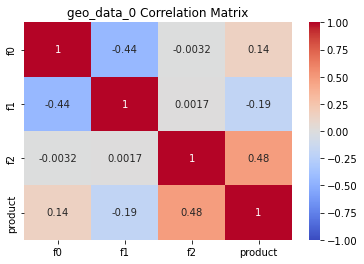

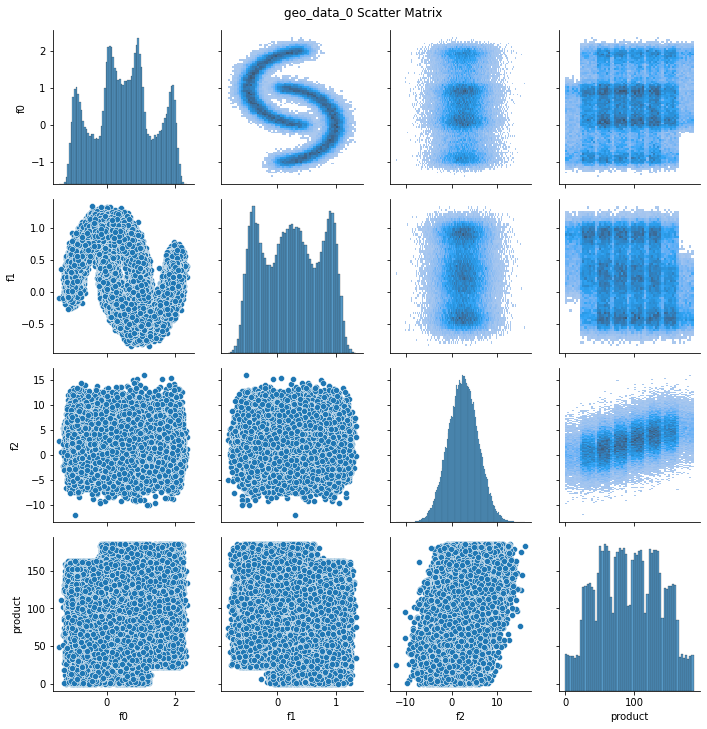

**geo_data_1**

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


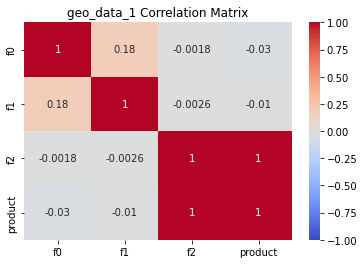

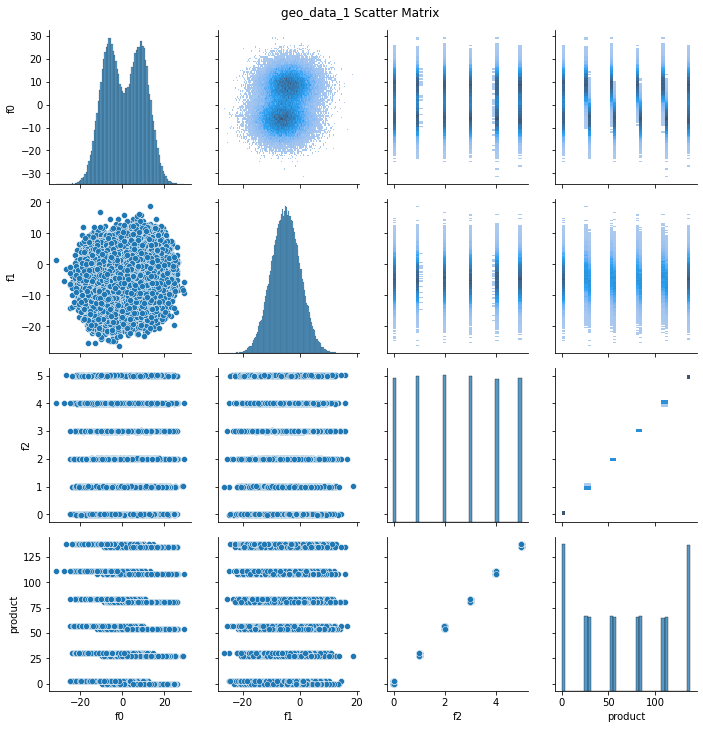

**geo_data_2**

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


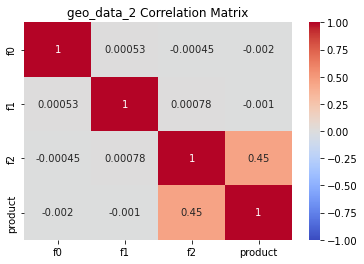

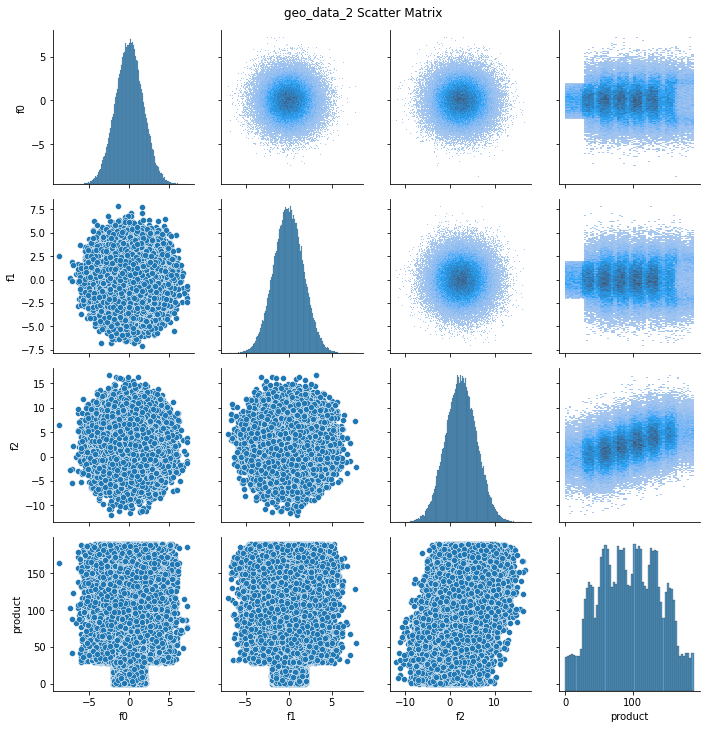

In [4]:
def show_scatter_and_corr(df):
    ''' Функция строит матрицу корреляции и матрицу рассеяния для переданного датафрейма 
    '''
    # коэффициенты корреляции
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);
    plt.title(df.name + ' Correlation Matrix');
    plt.show()
    # матрица рассеяния
    g = sns.PairGrid(df, diag_sharey=False)
    g.map_lower(sns.scatterplot)
    g.map_upper(sns.histplot)
    g.map_diag(sns.histplot)
    plt.suptitle(df.name + ' Scatter Matrix', y=1.01);
    plt.show()

# отобразим описательную статистику для данных из каждого региона
for df in data.values():
    display(Markdown('**'+df.name+'**'), df.describe())
    show_scatter_and_corr(df)

- В данных для всех регионов параметрр `f3` сильнее остальных корреллирует с целевым признаком. Особенно в данных `geo_data_1`, с таким коэффициентом корелляции и модели машинного обучения не нужны! - объёмы сырья прямопропорционально увеличиваются с ростом этого параметра

- Во всех случаях наблюдаемая целевая переменная не описывается нормальным распределением, поэтому для оценки доверительного интервала подойдёт техника бутстрепа

- Уже заметно, что регионы с индексами `0` и `2` имеют юлизкие средние значения запасов сырья, которое больше чем у региона `1`

## Обучение и проверка модели

Проведём обучение модели линейной регрессии на данных каждого региона по отдельности, сохраним предсказания, определим RMSE

In [5]:
def sampling(df, test_size=0.25, random_state=RANDOM_STATE):
    ''' Функция выделяет признаки и метки из датафрейма, делит их на обучающие и валидацоннные выборки 
    '''
    X = df.drop(['id','product'], axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    # выведем размеры выборок
    display(pd.DataFrame({
        'Выборка':  ['Исходная','Тренировочная','Валидационная'],
        'Признаки': [X.shape, X_train.shape, X_val.shape],
        'Метки':    [y.shape, y_train.shape, y_val.shape]
    }))

    return X_train, X_val, y_train, y_val


# обучение модели для каждого региона по отдельности
answers = {}        # словарь с целевыми значениями для каждого региона
predictions = {}    # словарь с предсказаниями
metrics_table = pd.DataFrame()  # информация с метриками
for df in data.values(): 
    print(df.name)
    X_train, X_val, y_train, y_val = sampling(df)
    # обучение и предсказания
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # сохраняем ответы и предсказания для региона
    answers[df.name] = np.array(y_val)
    predictions[df.name] = y_pred
    # таблица для вывода
    metrics_table[df.name]= pd.Series({
        'RMSE': mean_squared_error(y_val, y_pred, squared=False),
        'R2':  model.score(X_val, y_val),
        'Среднее по предсказаниям': y_pred.mean(),
        'Среднее по ответам': y_val.mean()
    })

display(Markdown('**Метрики**'))
metrics_table

geo_data_0


,Выборка,Признаки,Метки
0,Исходная,"(100000, 3)","(100000,)"
1,Тренировочная,"(75000, 3)","(75000,)"
2,Валидационная,"(25000, 3)","(25000,)"


geo_data_1


,Выборка,Признаки,Метки
0,Исходная,"(100000, 3)","(100000,)"
1,Тренировочная,"(75000, 3)","(75000,)"
2,Валидационная,"(25000, 3)","(25000,)"


geo_data_2


,Выборка,Признаки,Метки
0,Исходная,"(100000, 3)","(100000,)"
1,Тренировочная,"(75000, 3)","(75000,)"
2,Валидационная,"(25000, 3)","(25000,)"


**Метрики**

,geo_data_0,geo_data_1,geo_data_2
RMSE,37.647863,0.895414,40.128030
R2,0.281298,0.999618,0.193137
Среднее по предсказаниям,92.549362,69.280019,95.098599
Среднее по ответам,92.850624,69.273712,94.873488


- Наименьшая RMSE у региона `1`, при этом R2 почти равна 1 - на этих данных модель почти не ошибается. Неудивительно, в виду мультиколлинеарности признака `f3` и целевого признака
- У регионов `0` и `2` ошибки значительно больше. RMSE, немного меньше для нулевого датасета. Точность R2 здель ощутимо выше, чем у последнего датасета, вероятнее всего потому что зависимость целевого признака от остальных посильнее

Самое высокое среднее значение запасов модель предсказала для региона `2`

## Подготовка к расчёту прибыли

Оценим достаточный объём сырья для безубыточной разработки новой скважины.

Прибыль с одной скважины должна быть выше, чем бюджет, выделяемый на неё. Поэтому сначала вычислим бюджет на одну вышку - разделим весь бюджет `BUILD_BUDGET`, выделяемый на регион, на количество вышек `WELLS_CNT`, которое должны разработать в регионе

Это значение разделим на прибыль с 1 тысячи баррэлей `UNIT_INCOME` - получим оценочное значение объёма сырья, при котором доходы равны расходам

In [6]:
( BUILD_BUDGET / BEST_WELLS_CNT ) / UNIT_INCOME

111.11111111111111

Оценочное значение выше, чем средние значения запасов в любом из регионов, следовательно для минимизации рисков, надо отобрать точки которые потенциально могуть дать больше сырья. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [7]:
def profit(predicted, target, 
           wells_cnt=BEST_WELLS_CNT, unit_income=UNIT_INCOME, res_budget=BUILD_BUDGET):
    ''' Вычисление возможной чистой прибыли на известных значениях объёмов запасов

        Функция выбирает wells_cnt скважин с наибольшими значениями запасов из массива 
        предсказанных моделью значений, находит суммарный запас, 
        определяет доход с них умножением на цену единицы сырья unit_income и
        вычитает из этого числа значение бюджета на разработку budget 

        Параметры:
        predicted : numpy array - массив предсказанных значений запасов 
        target : numpy array - массив известных значений запасов 
        wells_cnt : int - число скважин, по которым считать
        unit_income : int/float - доход с единицы сырья (тыс. баррелей)
        res_budget : int/float - траты на разработку

        Возвращает: чистая прибыль (float)
    '''
    total_product = target[(-predicted).argsort()[:wells_cnt]].sum()
    return total_product * unit_income - res_budget

# проверка функции на всех предсказаниях
for region in predictions:
    print("{} : {:.3f} млн. руб.".format(region, profit(predictions[region], answers[region])/1e6))

geo_data_0 : 3534.671 млн. руб.
geo_data_1 : 2415.087 млн. руб.
geo_data_2 : 2370.344 млн. руб.


## Расчёт прибыли и рисков 

In [8]:
np.random.seed(RANDOM_STATE)

# расчитаем риски и прибыль в каждом регионе
result_table = pd.DataFrame()
for region in predictions:
    # предсказания и ответы для текущего региона
    product_pred = predictions[region]
    product_answ = answers[region]

    # bootstrap
    # список для значений прибыли, поссчитанных для каждой подвыбоки
    profits = []
    for i in range(1000):
        # генерируем индексы для выборки
        idx = np.random.randint(0, product_pred.shape[0], WELLS_CNT)
        # вызываем функцию расчёта прибыли, добавляем значение
        profits.append(profit(product_pred[idx], product_answ[idx]))

    # пределы доверительного интервала
    profits = pd.Series(profits)
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)

    result_table[region]= pd.Series({
        'Доверительный интервал, млн. руб.': (round(lower/1e6,2), round(upper/1e6,2)),
        'Средняя прибыль, млн. руб.': round(np.mean(profits)/1e6, 2),
        'Вероятность убытков, %': 100*(profits<0).astype(int).mean()
    })

display(Markdown("**95-процентный доверительный интервал, риски и прибыль**"))
result_table

**95-процентный доверительный интервал, риски и прибыль**

,geo_data_0,geo_data_1,geo_data_2
"Доверительный интервал, млн. руб.","(-57.99, 974.82)","(68.76, 871.49)","(-182.99, 870.97)"
"Средняя прибыль, млн. руб.",477.42,467.48,362.13
"Вероятность убытков, %",4.1,1.0,8.9


Исходя из условий задачи единственный подходящий регион - регион `1`, для него риски убытков минимальны, вероятность всего 1 процент. Кроме того фактическая средняя прибыль для него немного меньше, чем для региона `0` с макимальной прибылью.

Регионы `0` и `2` не подходят по причине высоких рисков, больше 2.5 %